In [1]:
import sys
!{sys.executable} -m pip install imbalanced-learn


In [2]:
# Week 3 - Supervised Learning: Classification
# COMP 9130 - Applied Artificial Intelligence
# Student Template

"""
🎯 TODAY'S GOALS:
1. Build logistic regression and decision tree classifiers
2. Implement Random Forest with hyperparameter tuning
3. Create confusion matrices and ROC curves
4. Handle imbalanced data using class_weight and SMOTE

📊 DATASET: Credit Card Fraud Detection
- 284,807 transactions
- Only 492 frauds (0.17% - highly imbalanced!)
- Features: Time, Amount, V1-V28 (PCA transformed)

⏰ TIME ALLOCATION:
- Task 1: 45 minutes (Logistic Regression & Decision Trees)
- Task 2: 45 minutes (Random Forest & GridSearchCV)
- Task 3: 55 minutes (Evaluation & Imbalanced Data)

💡 TIPS:
- Work with your pair partner - discuss before coding
- Read ALL instructions before starting each task
- Check your confusion matrices - accuracy is NOT enough!
- Ask for help if stuck for >5 minutes
"""

# ============================================================================
# SETUP: Run this cell first
# ============================================================================

# Install imbalanced-learn (for SMOTE)
!pip install imbalanced-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE

# Set random seed for reproducibility
np.random.seed(42)

# Plotting settings
plt.style.use('default')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ Ready to start!")

✓ All libraries imported successfully!
✓ NumPy version: 2.3.4
✓ Pandas version: 2.3.3
✓ Ready to start!


In [3]:
import pandas as pd
import os

csv_path = "creditcard.csv"
url = None  # replace with a real URL if you have it

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print("✓ Loaded from local file.")
elif url:
    df = pd.read_csv(url)
    print("✓ Loaded from URL.")
else:
    raise FileNotFoundError("creditcard.csv not found and no URL provided.")

print(f"✓ Data loaded! Shape: {df.shape}")
print(f"✓ Columns: {df.columns.tolist()}")

✓ Loaded from local file.
✓ Data loaded! Shape: (284807, 31)
✓ Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [4]:
# ============================================================================
# DATA LOADING
# ============================================================================

"""
DATASET OPTIONS:

Option 1: Download from Kaggle
- Go to: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
- Download creditcard.csv
- Upload to Colab using the file upload button

Option 2: Direct URL (if provided by instructor)
- Use the URL shared on Learning Hub
"""

# TODO: Upload the creditcard.csv file or load from provided URL

# Option 1: Load from uploaded file
df = pd.read_csv('creditcard.csv')

# Option 2: Load from URL (uncomment if instructor provides URL)
#url = 'YOUR_URL_HERE'
#df = pd.read_csv(url)

print(f"✓ Data loaded! Shape: {df.shape}")
print(f"✓ Columns: {df.columns.tolist()}")

✓ Data loaded! Shape: (284807, 31)
✓ Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']



EXPLORATORY DATA ANALYSIS

📊 First 5 rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



📋 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null 

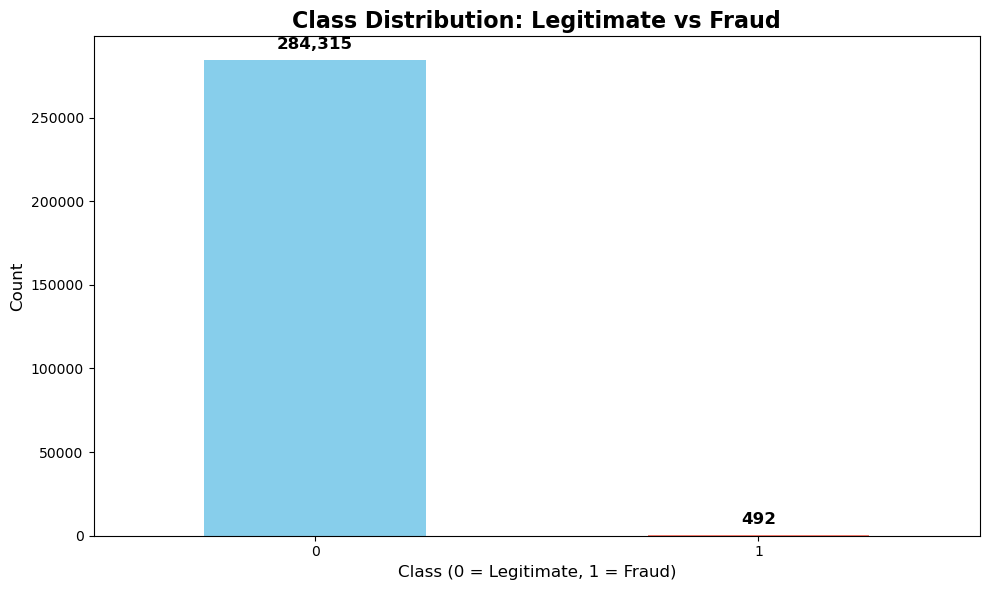


⚠️ IMBALANCE RATIO: 577.9:1
   For every 1 fraud transaction, there are 577.9 legitimate ones!
   Fraud percentage: 0.173%

📈 Statistical Summary:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


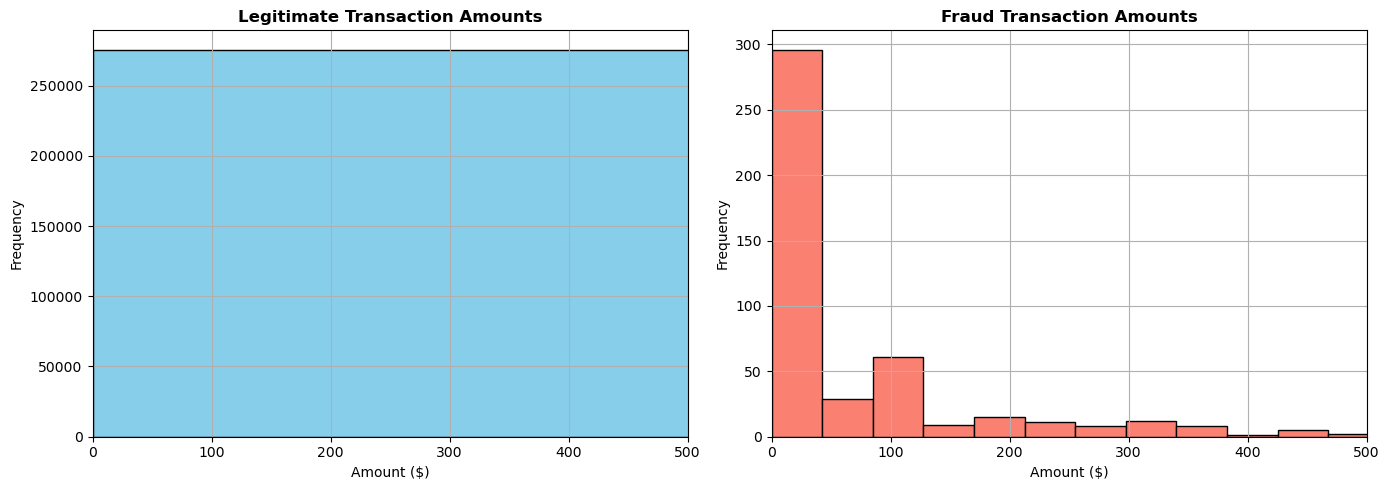


DATA PREPARATION

✓ Features shape: (284807, 30)
✓ Target shape: (284807,)
✓ Feature columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

✓ Training set: 227,845 samples
✓ Test set: 56,962 samples

📊 Train set class distribution:
Class
0    227451
1       394
Name: count, dtype: int64
   Fraud %: 0.173%

📊 Test set class distribution:
Class
0    56864
1       98
Name: count, dtype: int64
   Fraud %: 0.172%

✓ Features standardized (mean=0, std=1)
✓ Training features shape: (227845, 30)
✓ Test features shape: (56962, 30)

✓ Training data - Mean: -0.000000, Std: 1.000000
✓ Test data - Mean: -0.000127, Std: 1.004007


In [5]:
# ============================================================================
# EXPLORATORY DATA ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Display first few rows
print("\n📊 First 5 rows:")
display(df.head())

# Dataset info
print("\n📋 Dataset Information:")
print(df.info())

# Check for missing values
print("\n🔍 Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values! ✓")

# Target variable distribution
print("\n⚖️ Class Distribution:")
class_dist = df['Class'].value_counts()
print(class_dist)
print("\n📊 Class Balance:")
class_pct = df['Class'].value_counts(normalize=True) * 100
print(class_pct)

# Visualize class imbalance
plt.figure(figsize=(10, 6))
ax = df['Class'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution: Legitimate vs Fraud', fontsize=16, fontweight='bold')
plt.xlabel('Class (0 = Legitimate, 1 = Fraud)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

# Add count labels on bars
for i, v in enumerate(class_dist.values):
    ax.text(i, v + 5000, f'{v:,}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
fraud_count = df['Class'].sum()
legit_count = len(df) - fraud_count
imbalance_ratio = legit_count / fraud_count

print(f"\n⚠️ IMBALANCE RATIO: {imbalance_ratio:.1f}:1")
print(f"   For every 1 fraud transaction, there are {imbalance_ratio:.1f} legitimate ones!")
print(f"   Fraud percentage: {(fraud_count/len(df))*100:.3f}%")

# Statistical summary
print("\n📈 Statistical Summary:")
display(df.describe())

# Amount distribution by class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Legitimate transactions
df[df['Class'] == 0]['Amount'].hist(bins=50, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Legitimate Transaction Amounts', fontweight='bold')
axes[0].set_xlabel('Amount ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim([0, 500])

# Fraud transactions
df[df['Class'] == 1]['Amount'].hist(bins=50, ax=axes[1], color='salmon', edgecolor='black')
axes[1].set_title('Fraud Transaction Amounts', fontweight='bold')
axes[1].set_xlabel('Amount ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim([0, 500])

plt.tight_layout()
plt.show()

# ============================================================================
# DATA PREPARATION
# ============================================================================

print("\n" + "="*60)
print("DATA PREPARATION")
print("="*60)

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

print(f"\n✓ Features shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")
print(f"✓ Feature columns: {X.columns.tolist()}")

# Split data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # IMPORTANT: Maintain class distribution in splits
)

print(f"\n✓ Training set: {X_train.shape[0]:,} samples")
print(f"✓ Test set: {X_test.shape[0]:,} samples")

# Check class distribution in splits
print("\n📊 Train set class distribution:")
print(y_train.value_counts())
print(f"   Fraud %: {(y_train.sum()/len(y_train))*100:.3f}%")

print("\n📊 Test set class distribution:")
print(y_test.value_counts())
print(f"   Fraud %: {(y_test.sum()/len(y_test))*100:.3f}%")

# Standardize features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features standardized (mean=0, std=1)")
print(f"✓ Training features shape: {X_train_scaled.shape}")
print(f"✓ Test features shape: {X_test_scaled.shape}")

# Verify standardization
print(f"\n✓ Training data - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
print(f"✓ Test data - Mean: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.6f}")

In [6]:
# ============================================================================
# TASK 1: LOGISTIC REGRESSION & DECISION TREES (45 minutes)
# ============================================================================

"""
🎯 TASK 1 OBJECTIVES:
1. Build a Logistic Regression classifier
2. Build a Decision Tree classifier
3. Generate predictions from both models
4. Calculate and compare accuracy

📝 DELIVERABLES:
- Two trained models (logistic regression and decision tree)
- Predictions on test set
- Accuracy scores for both models
- Classification reports

⏰ TIME: 45 minutes
💯 POINTS: 5 points

💡 TIPS:
- Use max_iter=1000 for Logistic Regression (large dataset)
- Decision trees can overfit - we'll see this in Task 3
- Don't worry if accuracy seems very high - we'll investigate why
"""

print("\n" + "="*60)
print("TASK 1: LOGISTIC REGRESSION & DECISION TREES")
print("="*60)


TASK 1: LOGISTIC REGRESSION & DECISION TREES


In [7]:
# ----------------------------------------------------------------------------
# TODO 1.1: Train Logistic Regression Classifier
# ----------------------------------------------------------------------------

"""
INSTRUCTIONS:
1. Create a LogisticRegression model with max_iter=1000 and random_state=42
2. Fit the model on X_train_scaled and y_train
3. Generate predictions on X_test_scaled
4. Calculate accuracy score

HINT:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
"""

print("\n📊 1.1 LOGISTIC REGRESSION")
print("-" * 60)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# TODO: Create and train logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# TODO: Fit the model
log_reg.fit(X_train_scaled, y_train)

# TODO: Generate predictions
y_pred_log_reg = log_reg.predict(X_test_scaled)  # REPLACE: Generate predictions

# TODO: Calculate accuracy
from sklearn.metrics import accuracy_score
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)  # REPLACE: Calculate accuracy

print(f"✓ Logistic Regression Accuracy: {log_reg_accuracy:.4f}")

# Display classification report
print("\n📋 Logistic Regression Classification Report:")
# TODO: Print classification report
# HINT: from sklearn.metrics import classification_report

# YOUR CODE HERE
print("\n📋 Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))


📊 1.1 LOGISTIC REGRESSION
------------------------------------------------------------
✓ Logistic Regression Accuracy: 0.9991

📋 Logistic Regression Classification Report:

📋 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.63      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [8]:
# ----------------------------------------------------------------------------
# TODO 1.2: Train Decision Tree Classifier
# ----------------------------------------------------------------------------

"""
INSTRUCTIONS:
1. Create a DecisionTreeClassifier with random_state=42
2. Fit the model on X_train_scaled and y_train
3. Generate predictions on X_test_scaled
4. Calculate accuracy score

HINT:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_scaled, y_train)
"""

print("\n📊 1.2 DECISION TREE CLASSIFIER")
print("-" * 60)

# TODO: Create and train decision tree model
tree_clf = DecisionTreeClassifier(random_state=42)  # REPLACE: Create DecisionTreeClassifier

# TODO: Fit the model
# YOUR CODE HERE
tree_clf.fit(X_train_scaled, y_train)

# TODO: Generate predictions
y_pred_tree = tree_clf.predict(X_test_scaled)  # REPLACE: Generate predictions

# TODO: Calculate accuracy
tree_accuracy = accuracy_score(y_test, y_pred_tree)  # REPLACE: Calculate accuracy

print(f"✓ Decision Tree Accuracy: {tree_accuracy:.4f}")

# Display classification report
print("\n📋 Decision Tree Classification Report:")
# TODO: Print classification report
# YOUR CODE HERE
print("\n📋 Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree))


📊 1.2 DECISION TREE CLASSIFIER
------------------------------------------------------------
✓ Decision Tree Accuracy: 0.9991

📋 Decision Tree Classification Report:

📋 Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.75      0.74      0.75        98

    accuracy                           1.00     56962
   macro avg       0.88      0.87      0.87     56962
weighted avg       1.00      1.00      1.00     56962




📊 1.3 MODEL COMPARISON
------------------------------------------------------------

🏆 Model Comparison:


,Model,Accuracy,Fraud Precision,Fraud Recall,Fraud F1
0,Logistic Regression,0.99914,0.826667,0.632653,0.716763
1,Decision Tree,0.99914,0.752577,0.744898,0.748718



✓ Best Model by F1 Score: Decision Tree (F1: 0.7487)


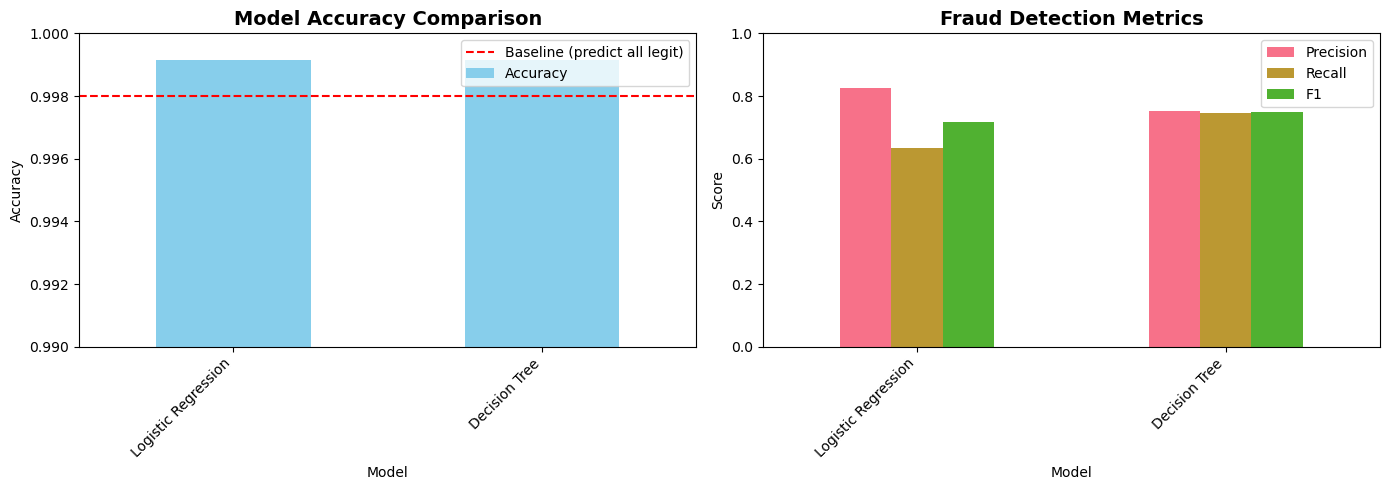


🤔 DISCUSSION WITH YOUR PARTNER:
1. Which model has higher accuracy?

2. Look at the classification report - what do you notice about

3. Is accuracy a good metric here? Why or why not?


In [9]:

# ----------------------------------------------------------------------------
# SOLUTION 1.3: Compare Models
# ----------------------------------------------------------------------------

print("\n📊 1.3 MODEL COMPARISON")
print("-" * 60)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy': [log_reg_accuracy, tree_accuracy],
    'Fraud Precision': [
        precision_score(y_test, y_pred_log_reg),
        precision_score(y_test, y_pred_tree)
    ],
    'Fraud Recall': [
        recall_score(y_test, y_pred_log_reg),
        recall_score(y_test, y_pred_tree)
    ],
    'Fraud F1': [
        f1_score(y_test, y_pred_log_reg),
        f1_score(y_test, y_pred_tree)
    ]
})

print("\n🏆 Model Comparison:")
display(comparison_df)

# Identify best model by F1 score
best_idx = comparison_df['Fraud F1'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_f1 = comparison_df.loc[best_idx, 'Fraud F1']

print(f"\n✓ Best Model by F1 Score: {best_model_name} (F1: {best_f1:.4f})")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
comparison_df.plot(x='Model', y='Accuracy', kind='bar', ax=axes[0],
                   color='skyblue', legend=False)
axes[0].set_title('Model Accuracy Comparison', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0.99, 1.0])
axes[0].axhline(y=0.998, color='red', linestyle='--', label='Baseline (predict all legit)')
axes[0].legend()
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')

# Fraud metrics comparison
metrics_to_plot = comparison_df[['Model', 'Fraud Precision', 'Fraud Recall', 'Fraud F1']]
metrics_to_plot.set_index('Model').plot(kind='bar', ax=axes[1])
axes[1].set_title('Fraud Detection Metrics', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Score')
axes[1].set_ylim([0, 1])
axes[1].legend(['Precision', 'Recall', 'F1'])
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 🤔 DISCUSSION QUESTIONS - PAUSE HERE FOR CLASS DISCUSSION
print("\n" + "="*60)
print("🤔 DISCUSSION WITH YOUR PARTNER:")
print("="*60)
print("1. Which model has higher accuracy?")
print("\n2. Look at the classification report - what do you notice about")
print("\n3. Is accuracy a good metric here? Why or why not?")
print("="*60)

In [10]:
# ============================================================================
# TASK 2: RANDOM FOREST & HYPERPARAMETER TUNING (45 minutes)
# ============================================================================

"""
🎯 TASK 2 OBJECTIVES:
1. Build a basic Random Forest classifier
2. Use GridSearchCV to find best hyperparameters
3. Compare Random Forest to single Decision Tree
4. Understand the impact of ensemble methods

📝 DELIVERABLES:
- Trained Random Forest model
- GridSearchCV results with best parameters
- Comparison of single tree vs forest performance

⏰ TIME: 45 minutes
💯 POINTS: 5 points

💡 TIPS:
- GridSearchCV will take 2-3 minutes - be patient!
- Use F1 score as scoring metric (better than accuracy for imbalanced data)
- Start with small parameter grid, can expand if time permits
"""

print("\n" + "="*60)
print("TASK 2: RANDOM FOREST & HYPERPARAMETER TUNING")
print("="*60)



TASK 2: RANDOM FOREST & HYPERPARAMETER TUNING


In [11]:
# ----------------------------------------------------------------------------
# TODO 2.1: Train Basic Random Forest
# ----------------------------------------------------------------------------

"""
INSTRUCTIONS:
1. Create a RandomForestClassifier with n_estimators=100 and random_state=42
2. Fit the model on training data
3. Generate predictions
4. Calculate accuracy and F1 score

HINT:
from sklearn.ensemble import RandomForestClassifier
rf_basic = RandomForestClassifier(n_estimators=100, random_state=42)
"""

print("\n📊 2.1 BASIC RANDOM FOREST")
print("-" * 60)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# TODO: Create and train basic Random Forest
rf_basic = RandomForestClassifier(n_estimators=100, random_state=42)  # REPLACE: Create RandomForestClassifier

# TODO: Fit the model
# YOUR CODE HERE
rf_basic.fit(X_train_scaled, y_train)

# TODO: Generate predictions
y_pred_rf_basic = rf_basic.predict(X_test_scaled)  # REPLACE: Generate predictions

# TODO: Calculate metrics
rf_basic_accuracy = accuracy_score(y_test, y_pred_rf_basic)
rf_basic_f1 = f1_score(y_test, y_pred_rf_basic, average="binary")

print(f"✓ Basic Random Forest Accuracy: {rf_basic_accuracy:.4f}")
print(f"✓ Basic Random Forest F1 Score: {rf_basic_f1:.4f}")

# Display classification report
print("\n📋 Basic Random Forest Classification Report:")
# TODO: Print classification report
# YOUR CODE HERE
print("\n📋 Basic Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_basic))


📊 2.1 BASIC RANDOM FOREST
------------------------------------------------------------
✓ Basic Random Forest Accuracy: 0.9996
✓ Basic Random Forest F1 Score: 0.8743

📋 Basic Random Forest Classification Report:

📋 Basic Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [12]:
# ----------------------------------------------------------------------------
# TODO 2.2: Hyperparameter Tuning with GridSearchCV
# ----------------------------------------------------------------------------

"""
INSTRUCTIONS:
1. Define a parameter grid with:
   - n_estimators: [50, 100, 200]
   - max_depth: [10, 20, None]
   - min_samples_split: [2, 5]
2. Create GridSearchCV with:
   - Random Forest estimator
   - Your parameter grid
   - cv=3 (3-fold cross-validation)
   - scoring='f1' (F1 score for imbalanced data)
   - n_jobs=-1 (use all CPU cores)
3. Fit GridSearchCV
4. Print best parameters and best score

⚠️ WARNING: This will take 2-3 minutes to run!

HINT:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
"""

print("\n📊 2.2 HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("-" * 60)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# TODO: Define parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5]
}

print("🔍 Parameter Grid:")
print(param_grid)
print(f"\n⏰ Total combinations to try: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split'])}")
print("⏰ This will take 2-3 minutes... ⏳")

# TODO: Create GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

# TODO: Fit GridSearchCV
print("\n🔄 Training models with GridSearchCV...")
# YOUR CODE HERE
grid_search.fit(X_train_scaled, y_train)

print("\n✓ GridSearchCV completed!")

# TODO: Print best parameters and score
print("\n🏆 BEST HYPERPARAMETERS:")
best_params = grid_search.best_params_
print(best_params)

print("\n📊 BEST F1 SCORE (from cross-validation):")
best_score = grid_search.best_score_
print(f"F1 Score: {best_score:.4f}")



📊 2.2 HYPERPARAMETER TUNING WITH GRIDSEARCHCV
------------------------------------------------------------
🔍 Parameter Grid:
{'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}

⏰ Total combinations to try: 18
⏰ This will take 2-3 minutes... ⏳

🔄 Training models with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

✓ GridSearchCV completed!

🏆 BEST HYPERPARAMETERS:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

📊 BEST F1 SCORE (from cross-validation):
F1 Score: 0.8436


In [13]:
# ----------------------------------------------------------------------------
# TODO 2.3: Evaluate Best Model
# ----------------------------------------------------------------------------

"""
INSTRUCTIONS:
1. Get the best model from GridSearchCV
2. Generate predictions on test set
3. Calculate accuracy and F1 score
4. Compare to basic Random Forest and Decision Tree
"""

print("\n📊 2.3 EVALUATE BEST MODEL")
print("-" * 60)

from sklearn.metrics import accuracy_score, f1_score, classification_report


# TODO: Get best model and make predictions
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test_scaled)

# TODO: Calculate metrics
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
best_rf_f1 = f1_score(y_test, y_pred_best_rf, average="binary")

print(f"✓ Best Random Forest Accuracy: {best_rf_accuracy:.4f}")
print(f"✓ Best Random Forest F1 Score: {best_rf_f1:.4f}")

# Display classification report
print("\n📋 Best Random Forest Classification Report:")
# TODO: Print classification report
# YOUR CODE HERE
print("\n📋 Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))


📊 2.3 EVALUATE BEST MODEL
------------------------------------------------------------
✓ Best Random Forest Accuracy: 0.9996
✓ Best Random Forest F1 Score: 0.8743

📋 Best Random Forest Classification Report:

📋 Best Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962




📊 2.4 COMPREHENSIVE MODEL COMPARISON
------------------------------------------------------------

🏆 MODEL COMPARISON TABLE:


,Model,Accuracy,F1 Score
0,Logistic Regression,0.999140,0.716763
1,Decision Tree,0.999140,0.748718
2,Random Forest (Basic),0.999596,0.874317
3,Random Forest (Tuned),0.999596,0.874317


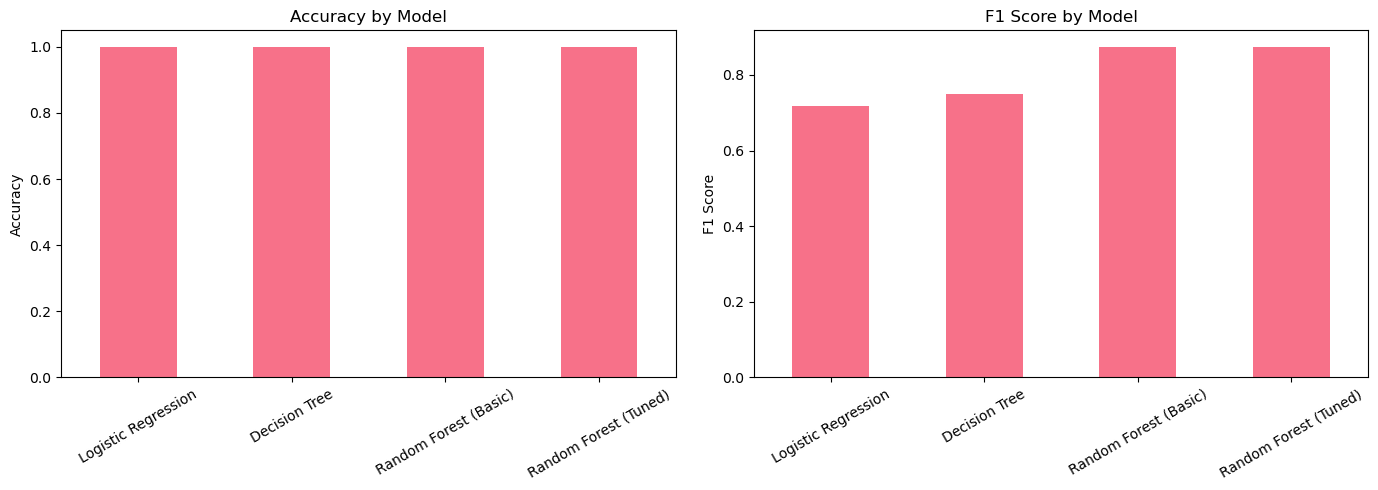


🤔 DISCUSSION WITH YOUR PARTNER:
1. How much did Random Forest improve over single Decision Tree?
2. Did hyperparameter tuning help? By how much?
3. Look at F1 scores - why are they lower than accuracy?
4. Which model would you choose and why?

✍️ Write your answers - you'll need them for the checkpoint!

✋ CHECKPOINT 2 - CALL INSTRUCTOR
Show your instructor:
  ✓ GridSearchCV completed with best parameters
  ✓ Model comparison table
  ✓ Your discussion answers


In [14]:
# ----------------------------------------------------------------------------
# TODO 2.4: Compare All Models
# ----------------------------------------------------------------------------

print("\n📊 2.4 COMPREHENSIVE MODEL COMPARISON")
print("-" * 60)

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Calculate F1 for Logistic Regression + Decision Tree (you already have predictions)
log_reg_f1 = f1_score(y_test, y_pred_log_reg, average="binary")
tree_f1 = f1_score(y_test, y_pred_tree, average="binary")

# TODO: Create comparison DataFrame
model_comparison = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Decision Tree",
        "Random Forest (Basic)",
        "Random Forest (Tuned)"
    ],
    "Accuracy": [
        log_reg_accuracy,
        tree_accuracy,
        rf_basic_accuracy,
        best_rf_accuracy
    ],
    "F1 Score": [
        log_reg_f1,
        tree_f1,
        rf_basic_f1,
        best_rf_f1
    ]
})

print("\n🏆 MODEL COMPARISON TABLE:")
display(model_comparison)

# TODO: Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# YOUR CODE HERE - Create bar plots for Accuracy and F1 Score
model_comparison.plot(x="Model", y="Accuracy", kind="bar", ax=ax1, legend=False, rot=30)
ax1.set_title("Accuracy by Model")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("")

model_comparison.plot(x="Model", y="F1 Score", kind="bar", ax=ax2, legend=False, rot=30)
ax2.set_title("F1 Score by Model")
ax2.set_ylabel("F1 Score")
ax2.set_xlabel("")

plt.tight_layout()
plt.show()

# 🤔 DISCUSSION QUESTION:
print("\n" + "="*60)
print("🤔 DISCUSSION WITH YOUR PARTNER:")
print("="*60)
print("1. How much did Random Forest improve over single Decision Tree?")
print("2. Did hyperparameter tuning help? By how much?")
print("3. Look at F1 scores - why are they lower than accuracy?")
print("4. Which model would you choose and why?")
print("\n✍️ Write your answers - you'll need them for the checkpoint!")
print("="*60)

# ✓ CHECKPOINT 2: Show instructor before proceeding
print("\n" + "="*60)
print("✋ CHECKPOINT 2 - CALL INSTRUCTOR")
print("="*60)
print("Show your instructor:")
print("  ✓ GridSearchCV completed with best parameters")
print("  ✓ Model comparison table")
print("  ✓ Your discussion answers")
print("="*60)

In [15]:
# ============================================================================
# TASK 3: EVALUATION & IMBALANCED DATA HANDLING (55 minutes)
# ============================================================================

"""
🎯 TASK 3 OBJECTIVES:
1. Create and interpret confusion matrices
2. Plot ROC curves and calculate AUC
3. Handle imbalanced data using class_weight
4. Handle imbalanced data using SMOTE
5. Compare approaches and analyze tradeoffs

📝 DELIVERABLES:
- Confusion matrices for all approaches
- ROC curve visualization
- Models trained with class_weight and SMOTE
- Written analysis of which approach is best for fraud detection

⏰ TIME: 55 minutes
💯 POINTS: 5 points

💡 TIPS:
- This is the MOST IMPORTANT task - understanding evaluation is key!
- Focus on FRAUD DETECTION performance (class 1), not overall accuracy
- Think about real-world implications: What's worse - false alarm or missed fraud?
- Your analysis answers matter more than perfect code
"""

print("\n" + "="*60)
print("TASK 3: EVALUATION & IMBALANCED DATA HANDLING")
print("="*60)


TASK 3: EVALUATION & IMBALANCED DATA HANDLING



📊 3.1 CONFUSION MATRIX ANALYSIS
------------------------------------------------------------
📊 Confusion Matrix:
[[56859     5]
 [   18    80]]


<Figure size 800x600 with 0 Axes>

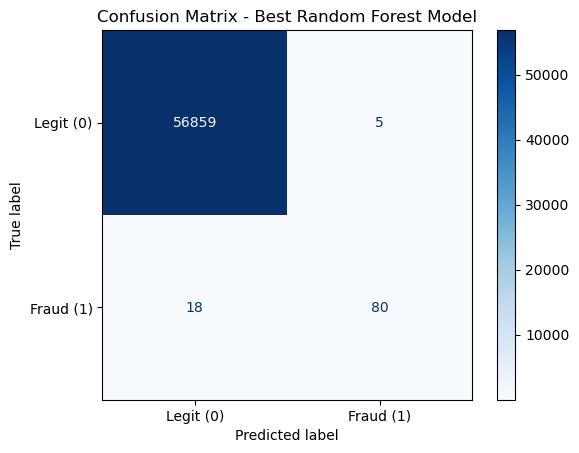


📋 Confusion Matrix Breakdown:
True Negatives (TN):  56,859 - Correctly identified legitimate
False Positives (FP): 5 - Falsely flagged as fraud (false alarm)
False Negatives (FN): 18 - Missed actual fraud (DANGEROUS!)
True Positives (TP):  80 - Correctly detected fraud

📊 Fraud Detection Performance (Class 1):
Precision: 0.9412 - Of flagged frauds, 94.12% were real
Recall:    0.8163 - Caught 81.63% of actual frauds
F1 Score:  0.8743 - Harmonic mean of precision and recall


In [16]:
# ----------------------------------------------------------------------------
# TODO 3.1: Confusion Matrix & Visualization
# ----------------------------------------------------------------------------

"""
INSTRUCTIONS:
1. Create confusion matrix for your best model (from Task 2)
2. Visualize using heatmap
3. Calculate precision, recall, F1 for fraud class specifically
4. Understand what each quadrant means

CONFUSION MATRIX REMINDER:
                Predicted
              Legit  Fraud
Actual Legit   TN     FP    (False Positive = False Alarm)
       Fraud   FN     TP    (False Negative = Missed Fraud)

For fraud detection:
- TP (True Positive): Correctly detected fraud ✓
- TN (True Negative): Correctly identified legitimate ✓
- FP (False Positive): Falsely flagged as fraud (customer annoyed)
- FN (False Negative): Missed actual fraud (bank loses money!)
"""

print("\n📊 3.1 CONFUSION MATRIX ANALYSIS")
print("-" * 60)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# TODO: Create confusion matrix for best model
cm = confusion_matrix(y_test, y_pred_best_rf)

print("📊 Confusion Matrix:")
print(cm)

# TODO: Visualize confusion matrix
plt.figure(figsize=(8, 6))
# YOUR CODE HERE - Use seaborn heatmap or ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit (0)", "Fraud (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Best Random Forest Model")
plt.show()

# Extract values from confusion matrix
tn, fp, fn, tp = cm.ravel()

print("\n📋 Confusion Matrix Breakdown:")
print(f"True Negatives (TN):  {tn:,} - Correctly identified legitimate")
print(f"False Positives (FP): {fp:,} - Falsely flagged as fraud (false alarm)")
print(f"False Negatives (FN): {fn:,} - Missed actual fraud (DANGEROUS!)")
print(f"True Positives (TP):  {tp:,} - Correctly detected fraud")

# TODO: Calculate metrics for fraud class (class 1)
fraud_precision = precision_score(y_test, y_pred_best_rf, pos_label=1)
fraud_recall = recall_score(y_test, y_pred_best_rf, pos_label=1)
fraud_f1 = f1_score(y_test, y_pred_best_rf, pos_label=1)

print("\n📊 Fraud Detection Performance (Class 1):")
print(f"Precision: {fraud_precision:.4f} - Of flagged frauds, {fraud_precision*100:.2f}% were real")
print(f"Recall:    {fraud_recall:.4f} - Caught {fraud_recall*100:.2f}% of actual frauds")
print(f"F1 Score:  {fraud_f1:.4f} - Harmonic mean of precision and recall")


📊 3.2 ROC CURVE & AUC
------------------------------------------------------------
✓ ROC-AUC Score: 0.9630


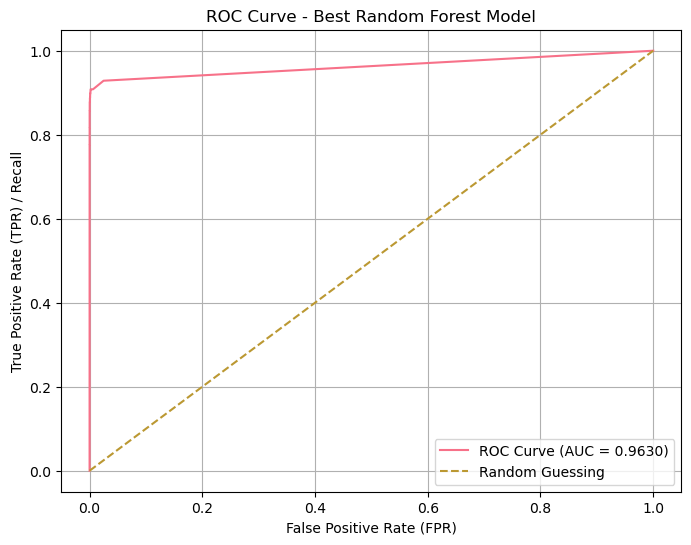

In [17]:
# ----------------------------------------------------------------------------
# TODO 3.2: ROC Curve & AUC
# ----------------------------------------------------------------------------

"""
INSTRUCTIONS:
1. Get probability predictions (not just class predictions)
2. Calculate ROC curve
3. Calculate AUC (Area Under Curve)
4. Plot ROC curve

ROC CURVE:
- X-axis: False Positive Rate (FPR)
- Y-axis: True Positive Rate (TPR) = Recall
- Diagonal line = random guessing (AUC = 0.5)
- Perfect model = top-left corner (AUC = 1.0)
- AUC 0.8-0.9 = good performance
"""

print("\n📊 3.2 ROC CURVE & AUC")
print("-" * 60)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# TODO: Get probability predictions for positive class
y_pred_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# TODO: Calculate AUC
roc_auc = auc(fpr, tpr)

print(f"✓ ROC-AUC Score: {roc_auc:.4f}")

# TODO: Plot ROC curve

# YOUR CODE HERE - Complete the plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guessing")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR) / Recall")
plt.title("ROC Curve - Best Random Forest Model")
plt.legend()
plt.grid(True)
plt.show()


📊 3.3 APPROACH 1: CLASS WEIGHTS
------------------------------------------------------------
🎯 Training Random Forest with balanced class weights...
   This penalizes mistakes on the minority class (fraud) more heavily

📊 Confusion Matrix (with Class Weights):
[[56861     3]
 [   25    73]]


<Figure size 800x600 with 0 Axes>

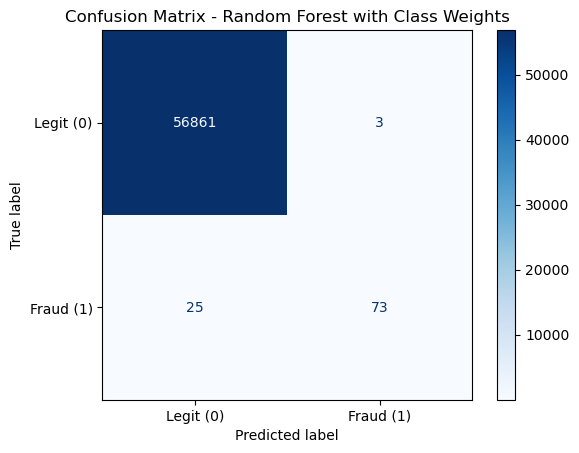


📊 Fraud Detection Performance (Class Weights):
Precision: 0.9605
Recall:    0.7449
F1 Score:  0.8391


In [18]:
# ----------------------------------------------------------------------------
# TODO 3.3: Handle Imbalance - Approach 1 (Class Weights)
# ----------------------------------------------------------------------------

"""
INSTRUCTIONS:
1. Train new Random Forest with class_weight='balanced'
2. This tells the model: "Mistakes on fraud cost more!"
3. Generate predictions and create confusion matrix
4. Compare to original model

EXPECTED RESULT:
- Higher recall (catch more fraud)
- Lower precision (more false alarms)
- Tradeoff: Better safe than sorry!
"""

print("\n📊 3.3 APPROACH 1: CLASS WEIGHTS")
print("-" * 60)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

print("🎯 Training Random Forest with balanced class weights...")
print("   This penalizes mistakes on the minority class (fraud) more heavily")

# TODO: Create and train Random Forest with class_weight='balanced'
rf_weighted = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

# TODO: Fit and predict
# YOUR CODE HERE
rf_weighted.fit(X_train_scaled, y_train)

# TODO: Generate predictions
y_pred_weighted = rf_weighted.predict(X_test_scaled)

# TODO: Create confusion matrix
cm_weighted = confusion_matrix(y_test, y_pred_weighted)

print("\n📊 Confusion Matrix (with Class Weights):")
print(cm_weighted)

# TODO: Visualize confusion matrix
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_weighted, display_labels=["Legit (0)", "Fraud (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest with Class Weights")
plt.show()

# TODO: Calculate metrics
weighted_precision = precision_score(y_test, y_pred_weighted, pos_label=1)
weighted_recall = recall_score(y_test, y_pred_weighted, pos_label=1)
weighted_f1 = f1_score(y_test, y_pred_weighted, pos_label=1)

print("\n📊 Fraud Detection Performance (Class Weights):")
print(f"Precision: {weighted_precision:.4f}")
print(f"Recall:    {weighted_recall:.4f}")
print(f"F1 Score:  {weighted_f1:.4f}")



📊 3.4 APPROACH 2: SMOTE (SYNTHETIC MINORITY OVERSAMPLING)
------------------------------------------------------------
🔄 Applying SMOTE to training data...
   This creates synthetic fraud examples to balance the classes

📊 Before SMOTE:
   Legitimate: 227,451
   Fraud:      394

📊 After SMOTE:
   Legitimate: 227,451
   Fraud:      227,451

🎯 Training Random Forest on SMOTE-balanced data...

📊 Confusion Matrix (with SMOTE):
[[56852    12]
 [   17    81]]


<Figure size 800x600 with 0 Axes>

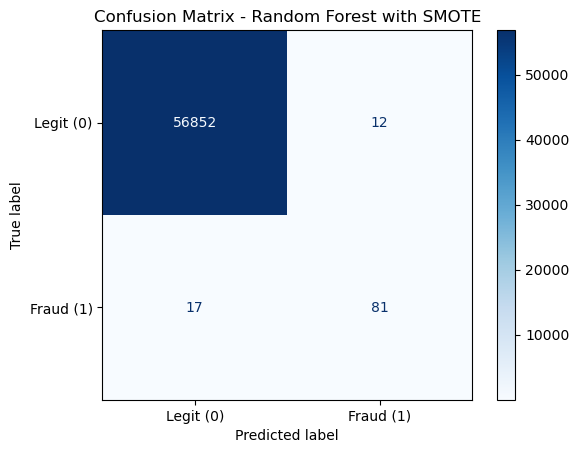


📊 Fraud Detection Performance (SMOTE):
Precision: 0.8710
Recall:    0.8265
F1 Score:  0.8482


In [19]:
# ----------------------------------------------------------------------------
# TODO 3.4: Handle Imbalance - Approach 2 (SMOTE)
# ----------------------------------------------------------------------------

"""
INSTRUCTIONS:
1. Apply SMOTE to training data ONLY (never test data!)
2. SMOTE creates synthetic fraud examples by interpolating
3. Train Random Forest on balanced data
4. Generate predictions and create confusion matrix
5. Compare to class_weight approach

⚠️ CRITICAL: Only apply SMOTE to training data!

EXPECTED RESULT:
- Similar to class_weight approach
- May be slightly better or worse
- Takes longer to train (more data)
"""

print("\n📊 3.4 APPROACH 2: SMOTE (SYNTHETIC MINORITY OVERSAMPLING)")
print("-" * 60)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

print("🔄 Applying SMOTE to training data...")
print("   This creates synthetic fraud examples to balance the classes")

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\n📊 Before SMOTE:")
print(f"   Legitimate: {(y_train == 0).sum():,}")
print(f"   Fraud:      {(y_train == 1).sum():,}")

print(f"\n📊 After SMOTE:")
print(f"   Legitimate: {(y_train_smote == 0).sum():,}")
print(f"   Fraud:      {(y_train_smote == 1).sum():,}")

# TODO: Train Random Forest on SMOTE-balanced data
rf_smote = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# TODO: Fit and predict
print("\n🎯 Training Random Forest on SMOTE-balanced data...")
# YOUR CODE HERE
rf_smote.fit(X_train_smote, y_train_smote)

# TODO: Generate predictions on original test set (not SMOTE'd!)
y_pred_smote = rf_smote.predict(X_test_scaled)

# TODO: Create confusion matrix
cm_smote = confusion_matrix(y_test, y_pred_smote)

print("\n📊 Confusion Matrix (with SMOTE):")
print(cm_smote)

# TODO: Visualize confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=["Legit (0)", "Fraud (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest with SMOTE")
plt.show()

# TODO: Calculate metrics
smote_precision = precision_score(y_test, y_pred_smote, pos_label=1)
smote_recall = recall_score(y_test, y_pred_smote, pos_label=1)
smote_f1 = f1_score(y_test, y_pred_smote, pos_label=1)

print("\n📊 Fraud Detection Performance (SMOTE):")
print(f"Precision: {smote_precision:.4f}")
print(f"Recall:    {smote_recall:.4f}")
print(f"F1 Score:  {smote_f1:.4f}")


📊 3.5 COMPREHENSIVE COMPARISON
------------------------------------------------------------

🏆 APPROACH COMPARISON TABLE:


,Approach,Precision,Recall,F1 Score
0,Original Model,0.941176,0.816327,0.874317
1,Class Weights,0.960526,0.744898,0.839080
2,SMOTE,0.870968,0.826531,0.848168


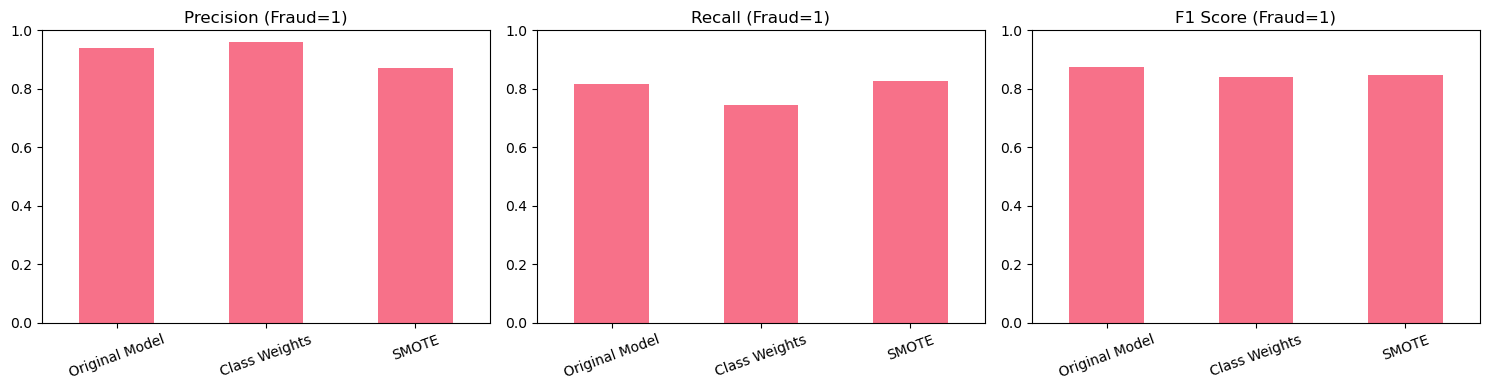

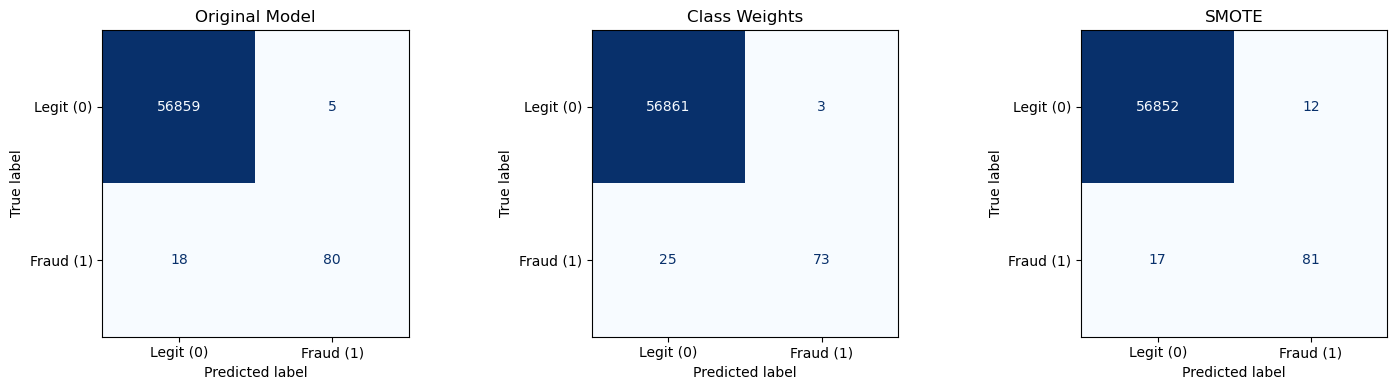


📝 ANALYSIS QUESTIONS - ANSWER BASED ON YOUR RESULTS

1️⃣ RECALL COMPARISON:
   Which approach detected the MOST fraud (highest recall)?
   Provide the specific recall values for all three approaches.
   
   YOUR ANSWER:
  HighesOriginal Model Recall: 0.8163
           Class Weights Recall: 0.7449S
           MOTE Recall: 0.8265t recall = SMOTE (0.8265)
   

2️⃣ PRECISION COMPARISON:
   Which approach had the FEWEST false alarms (highest precision)?
   Provide the specific precision values for all three approaches.
   
   YOUR ANSWER:
   Highest precision = Class Weights (0.9605)
            Original Model Precision: 0.9412
            Class Weights Precision: 0.9605
            SMOTE Precision: 0.8710
   

3️⃣ PRECISION-RECALL TRADEOFF:
   Explain the tradeoff you observed between precision and recall.
   When recall goes up, what happens to precision? Why?
   
   YOUR ANSWER:
 In my results, increasing recall did not always increase precision.
          SMOTE had the highest recall (

In [20]:
# ----------------------------------------------------------------------------
# TODO 3.5: Compare All Approaches
# ----------------------------------------------------------------------------

print("\n📊 3.5 COMPREHENSIVE COMPARISON")
print("-" * 60)

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# TODO: Create comparison DataFrame
imbalance_comparison = pd.DataFrame({
    "Approach": ["Original Model", "Class Weights", "SMOTE"],
    "Precision": [fraud_precision, weighted_precision, smote_precision],
    "Recall":    [fraud_recall,    weighted_recall,    smote_recall],
    "F1 Score":  [fraud_f1,        weighted_f1,        smote_f1]
})

print("\n🏆 APPROACH COMPARISON TABLE:")
display(imbalance_comparison)

# TODO: Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# YOUR CODE HERE - Create bar plots for Precision, Recall, F1

imbalance_comparison.plot(x="Approach", y="Precision", kind="bar", ax=axes[0], legend=False, rot=20)
axes[0].set_title("Precision (Fraud=1)")
axes[0].set_ylim(0, 1)
axes[0].set_xlabel("")

imbalance_comparison.plot(x="Approach", y="Recall", kind="bar", ax=axes[1], legend=False, rot=20)
axes[1].set_title("Recall (Fraud=1)")
axes[1].set_ylim(0, 1)
axes[1].set_xlabel("")

imbalance_comparison.plot(x="Approach", y="F1 Score", kind="bar", ax=axes[2], legend=False, rot=20)
axes[2].set_title("F1 Score (Fraud=1)")
axes[2].set_ylim(0, 1)
axes[2].set_xlabel("")

plt.tight_layout()
plt.show()

# TODO: Side-by-side confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# YOUR CODE HERE - Show all three confusion matrices side by side
ConfusionMatrixDisplay(cm, display_labels=["Legit (0)", "Fraud (1)"]).plot(
    ax=axes[0], cmap="Blues", values_format="d", colorbar=False
)
axes[0].set_title("Original Model")

ConfusionMatrixDisplay(cm_weighted, display_labels=["Legit (0)", "Fraud (1)"]).plot(
    ax=axes[1], cmap="Blues", values_format="d", colorbar=False
)
axes[1].set_title("Class Weights")

ConfusionMatrixDisplay(cm_smote, display_labels=["Legit (0)", "Fraud (1)"]).plot(
    ax=axes[2], cmap="Blues", values_format="d", colorbar=False
)
axes[2].set_title("SMOTE")

plt.tight_layout()
plt.show()

# ============================================================================
# ANALYSIS QUESTIONS (REQUIRED - WORTH FULL POINTS!)
# ============================================================================

print("\n" + "="*60)
print("📝 ANALYSIS QUESTIONS - ANSWER BASED ON YOUR RESULTS")
print("="*60)

"""
⚠️ IMPORTANT: These questions are required for full points!
Answer based on YOUR actual results, not generic statements.
Reference specific numbers from your confusion matrices and metrics.

Write your answers in this cell or in a separate markdown cell below.
"""

print("\n1️⃣ RECALL COMPARISON:")
print("   Which approach detected the MOST fraud (highest recall)?")
print("   Provide the specific recall values for all three approaches.")
print("   ")
print("   YOUR ANSWER:")
print("""  HighesOriginal Model Recall: 0.8163
           Class Weights Recall: 0.7449S
           MOTE Recall: 0.8265t recall = SMOTE (0.8265)""")
print("   ")

print("\n2️⃣ PRECISION COMPARISON:")
print("   Which approach had the FEWEST false alarms (highest precision)?")
print("   Provide the specific precision values for all three approaches.")
print("   ")
print("   YOUR ANSWER:")
print("""   Highest precision = Class Weights (0.9605)
            Original Model Precision: 0.9412
            Class Weights Precision: 0.9605
            SMOTE Precision: 0.8710""")
print("   ")

print("\n3️⃣ PRECISION-RECALL TRADEOFF:")
print("   Explain the tradeoff you observed between precision and recall.")
print("   When recall goes up, what happens to precision? Why?")
print("   ")
print("   YOUR ANSWER:")
print(""" In my results, increasing recall did not always increase precision.
          SMOTE had the highest recall (0.8265) but lowest precision (0.8710).
          it catches more fraud, but also flags more legitimate transactions 
          as fraud (more false positives).Class Weights had the highest precision
          (0.9605) but the lowest recall (0.7449),
          it avoids false alarms but misses more fraud (more false negatives).
          When the model tries to catch more fraud (higher recall), it usually
          becomes more aggressive and increases false alarms (lower precision).""")
print("   ")

print("\n4️⃣ BUSINESS DECISION:")
print("   For credit card fraud detection, which approach would you deploy")
print("   in production? Justify your choice by considering:")
print("   - Cost of missing fraud (false negative)")
print("   - Cost of false alarms (false positive)")
print("   - Customer experience")
print("   ")
print("   YOUR ANSWER:")
print(""" For real credit card fraud detection, I would deploy SMOTE, 
          because it has the highest recall (0.8265) and catches the most fraud.
          Justification:
          False negatives (missed fraud) cause direct financial loss to the bank and are very dangerous.
          False positives (false alarms) may annoy customers, but are usually less costly than missing real fraud.
          SMOTE gives the best fraud-catching performance overall in my results.
          Production choice: SMOTE
          """)
print("   ")

print("\n5️⃣ CONFUSION MATRIX INSIGHTS:")
print("   Look at the False Negatives (missed frauds) across all three approaches.")
print("   How many frauds did each approach miss? Which is most dangerous?")
print("   ")
print("   YOUR ANSWER:")
print(""" Original Model FN: 18
          Class Weights FN: 25
          SMOTE FN: 17
          The most dangerous approach is Class Weights, because it missed the most fraud (FN = 25).
          The safest approach is SMOTE, because it missed the fewest fraud (FN = 17).
          """)
print("   ")

print("\n6️⃣ CLASS WEIGHTS VS SMOTE:")
print("   Both approaches try to handle imbalanced data. Based on your results,")
print("   which worked better? Did one take longer to train? Would you recommend")
print("   one over the other?")
print("   ")
print("   YOUR ANSWER:")
print(""" Class Weights
          Precision 0.9605 <-best
          Recall 0.7449 <- worst
          F1 0.8391
          SMOTE
          Precision 0.8710
          Recall 0.8265 <- best
          F1 0.8482 <- better
          Which worked better? -> SMOTE
          Because it has higher recall and slightly better F1 score,
          which matters most in fraud detection.
          """)
print("   ")

# ✓ CHECKPOINT 3: Show instructor for final evaluation
print("\n" + "="*60)
print("✋ CHECKPOINT 3 - CALL INSTRUCTOR FOR FINAL EVALUATION")
print("="*60)
print("Show your instructor:")
print("  ✓ All three confusion matrices (Original, Class Weights, SMOTE)")
print("  ✓ ROC curve plotted")
print("  ✓ Comparison table with all metrics")
print("  ✓ All 6 analysis questions answered with specific references to YOUR results")
print("  ✓ Thoughtful justification showing understanding of tradeoffs")
print("\n💯 GRADING CRITERIA:")
print("  5 points: All visualizations + both approaches + thoughtful analysis")
print("  3 points: Most visualizations + one approach + basic analysis")
print("  1 point: Some progress + superficial analysis")
print("="*60)